In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import joblib
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar el dataset procesado que guardamos antes
df = pd.read_csv('../data/processed/EDA_FINAL.csv')

In [3]:
# DEFINICIÓN DE COLUMNAS
num_features = [
    'age_group', 
    'tumor_category',  
    'income_level',
    'Total number of in situ/malignant tumors for patient'
]

cat_features = [
    'tratamiento',
    'Stage_Final',
    'Sex',
    'grade_clinical',
    'histology_type_named'
]

cortes = [12, 24, 36, 48, 60]
modelos_finales = {}

--- ENTRENAMIENTO CON FILTRO DINÁMICO POR HITO ---


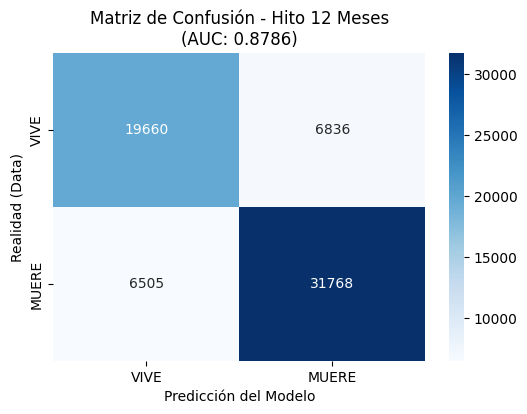

              precision    recall  f1-score   support

           0       0.75      0.74      0.75     26496
           1       0.82      0.83      0.83     38273

    accuracy                           0.79     64769
   macro avg       0.79      0.79      0.79     64769
weighted avg       0.79      0.79      0.79     64769



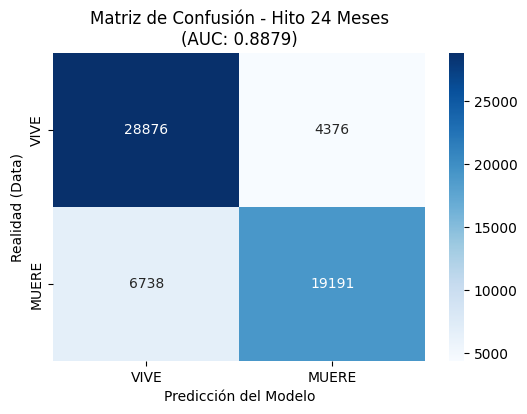

              precision    recall  f1-score   support

           0       0.81      0.87      0.84     33252
           1       0.81      0.74      0.78     25929

    accuracy                           0.81     59181
   macro avg       0.81      0.80      0.81     59181
weighted avg       0.81      0.81      0.81     59181



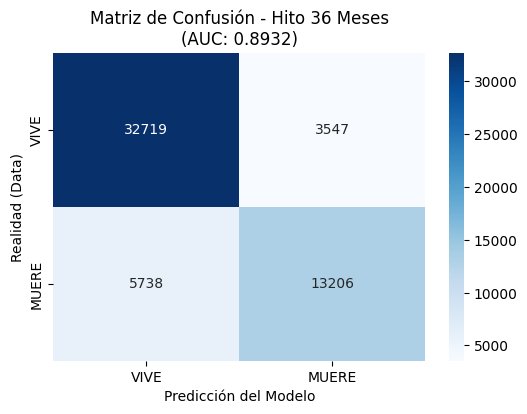

              precision    recall  f1-score   support

           0       0.85      0.90      0.88     36266
           1       0.79      0.70      0.74     18944

    accuracy                           0.83     55210
   macro avg       0.82      0.80      0.81     55210
weighted avg       0.83      0.83      0.83     55210



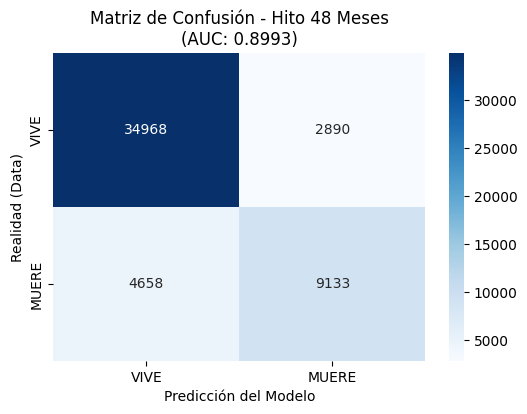

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     37858
           1       0.76      0.66      0.71     13791

    accuracy                           0.85     51649
   macro avg       0.82      0.79      0.81     51649
weighted avg       0.85      0.85      0.85     51649



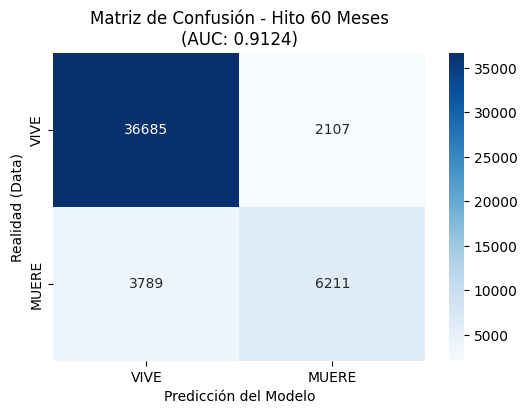

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     38792
           1       0.75      0.62      0.68     10000

    accuracy                           0.88     48792
   macro avg       0.83      0.78      0.80     48792
weighted avg       0.87      0.88      0.87     48792

--------------------------------------------------
--- TODOS LOS MODELOS ENTRENADOS Y GUARDADOS ---


In [4]:
print("--- ENTRENAMIENTO CON FILTRO DINÁMICO POR HITO ---")

for meses in cortes:
    # FILTRADO ESPECÍFICO PARA ESTE HITO
    condicion_muerte = (df['target_cancer_survival'] == 0)
    condicion_vivo_suficiente = (df['target_cancer_survival'] == 1) & (df['survival_months_int'] >= meses)
    
    df_hito = df[condicion_muerte | condicion_vivo_suficiente].copy()
    
    # DEFINIR EL TARGET
    target_col = f'target_{meses}_m'
    df_hito[target_col] = np.where(
        (df_hito['target_cancer_survival'] == 0) & (df_hito['survival_months_int'] <= meses), 0, 1
    )
    
    # SELECCIÓN DE CARACTERÍSTICAS Y SPLIT
    X = df_hito[num_features + cat_features]
    y = df_hito[target_col]
    
    # usa stratify=y para mantener la proporción de muertes en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Define el preprocessor dentro del bucle para asegurar limpieza
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features)
        ])

    # PIPELINE
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(n_estimators=150, learning_rate=0.1, max_depth=6, subsample=0.8, random_state=42))
    ])
    
    # Entrenamiento
    pipeline.fit(X_train, y_train)
    
   # EVALUACIÓN Y GRÁFICO
    y_pred = pipeline.predict(X_test)
    auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    cm = confusion_matrix(y_test, y_pred)

    # Generar el Heatmap de Seaborn 
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['VIVE', 'MUERE'], 
                yticklabels=['VIVE', 'MUERE'])
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Realidad (Data)')
    plt.title(f'Matriz de Confusión - Hito {meses} Meses\n(AUC: {auc:.4f})')
    plt.show()
    
    # Imprime precisión y sensibilidad
    print(classification_report(y_test, y_pred)) 
    
    # Guardar cada pipeline por separado
    joblib.dump(pipeline, f'../webapp/model/pipeline_{meses}m.pkl')

print("-" * 50)
print("--- TODOS LOS MODELOS ENTRENADOS Y GUARDADOS ---")

In [5]:
# CONFIGURACIÓN INICIAL
# Selecciona al paciente y define los cortes
paciente_base = df.iloc[10]
trat_actual = paciente_base['tratamiento']
print(f"Tratamiento detectado en el paciente: {trat_actual}")

cortes_grafico = [0, 12, 24, 36, 48, 60]
cortes_modelos = [12, 24, 36, 48, 60]

# MAPEO DE RECHAZO / COMPARATIVAS
mapeo_rechazo = {
    'C + Q + Rnor': ['C + Q + Rnor', 'Cr + Q + Rnor'],
    'Cn + Q + Rs': ['Cn + Q + Rs', 'Cn + Q + Rr'],
    'C + nQ + Rnor': ['C + nQ + Rnor', 'Cr + nQ + Rnor'],
    'Cn + nQ + Rnor': ['Cn + nQ + Rnor'],
    'Cn + nQ + Rs': [ 'Cn + nQ + Rs', 'Cn + nQ + Rr'], 
    'Cn + Q + Rnor': ['Cn + Q + Rnor','Cn + nQ + Rnor'], 
    'C + nQ + Rr': ['C + nQ + Rr', 'Cr + nQ + Rr', 'C + nQ + Rs', 'Cr + nQ + Rs'] , 
    'C + Q + Rs': ['C + Q + Rs', 'Cr + Q + Rs', 'C + Q + Rr', 'Cr + Q + Rr'],
    'Cn + nQ + Rr': ['Cn + nQ + Rr', 'Cn + nQ + Rs'], 
    'C + Q + Rr': ['C + Q + Rr', 'C + Q + Rs', 'Cr + Q + Rs'], 
    'Cr + nQ + Rs': ['Cr + nQ + Rs', 'C + nQ + Rs', 'C + nQ + Rr', 'Cr + nQ + Rr'], 
    'Cr + nQ + Rr': ['Cr + nQ + Rr', 'C + nQ + Rr', 'Cr + nQ + Rs'],
    'C + nQ + Rs': ['C + nQ + Rs', 'Cr + nQ + Rs', 'C + nQ + Rr', 'Cr + nQ + Rr'], 
    'Cr + nQ + Rnor': ['Cr + nQ + Rnor', 'C + nQ + Rnor'],
    'Cn + Q + Rr': ['Cn + Q + Rr', 'Cn + Q + Rs'], 
    'Cr + Q + Rs': ['Cr + Q + Rs', 'C + Q + Rs', 'C + Q + Rr'],
    'Cr + Q + Rnor': ['Cr + Q + Rnor', 'C + Q + Rnor'], 
    'Cr + Q + Rr': ['Cr + Q + Rr', 'C + Q + Rr', 'Cr + Q + Rs', 'C + Q + Rs']
}


Tratamiento detectado en el paciente: Cn + nQ + Rs


In [6]:
# CARGAR MODELOS
# Asegura de que los archivos .pkl existan en la ruta
modelos = {m: joblib.load(f'pipeline_{m}m.pkl') for m in cortes_modelos}

# PREPARAR  LA LISTA DE TRATAMIENTOS A GRAFICAR
lista_a_graficar = mapeo_rechazo.get(trat_actual, [trat_actual])

# Configuración dinámica del layout de los gráficos
n_graficos = len(lista_a_graficar)
cols = 2 if n_graficos <= 2 else 4
filas = (n_graficos // cols) + (1 if n_graficos % cols != 0 else 0)

fig, axes = plt.subplots(filas, cols, figsize=(18, 5 * filas), squeeze=False)
axes = axes.flatten()

# BUCLE DE PREDICCIÓN Y GENERACIÓN DE GRÁFICOS
for i, trat in enumerate(lista_a_graficar):
    # Crea el escenario para el tratamiento específico
    datos_escenario = paciente_base.copy()
    datos_escenario['tratamiento'] = trat
    df_escenario = pd.DataFrame([datos_escenario])
    
    # Probabilidad inicial
    supervivencia = [1.0]
    ultimo_riesgo_muerte = 0.0 
    
    for m in cortes_modelos:
        # Predicción de probabilidades [Prob_Vive, Prob_Muere]
        probs = modelos[m].predict_proba(df_escenario)[0]
        p_muerte = probs[0]
        
        # CORRECCIÓN MONÓTONA: El riesgo de muerte acumulado no puede bajar
        if p_muerte < ultimo_riesgo_muerte:
            p_muerte = ultimo_riesgo_muerte
        
        supervivencia.append(1 - p_muerte)
        ultimo_riesgo_muerte = p_muerte
    
    # Graficar en el subeje correspondiente
    ax = axes[i]
    # Color verde para el actual, azul para comparativas
    color_pila = 'forestgreen' if trat == trat_actual else 'royalblue'
    
    ax.plot(cortes_grafico, supervivencia, marker='o', linewidth=3, color=color_pila, label='Supervivencia')
    ax.fill_between(cortes_grafico, supervivencia, color=color_pila, alpha=0.15)
    
    # Personalización de cada gráfico
    status = "(ACTUAL)" if trat == trat_actual else "(RECHAZO/ALT)"
    ax.set_title(f"{status}\n{trat}", fontsize=11, fontweight='bold')
    ax.set_xticks(cortes_grafico)
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle=':', alpha=0.6)
    
    # Añade porcentaje final a los 60 meses para lectura rápida
    ax.text(60, supervivencia[-1] + 0.02, f"{supervivencia[-1]*100:.1f}%", 
            ha='center', fontweight='bold', color=color_pila)

    if i >= (filas - 1) * cols: ax.set_xlabel("Meses")
    if i % cols == 0: ax.set_ylabel("Prob. Supervivencia")

# Oculta ejes sobrantes si el número de gráficos no llena la cuadrícula
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# ESTÉTICA FINAL
plt.tight_layout()
plt.suptitle(f"SIMULACIÓN DE ESCENARIOS: Impacto del Tratamiento en Supervivencia\nPaciente ID: {paciente_base.name} | Tratamiento Base: {trat_actual}", 
             fontsize=16, y=1.05, fontweight='bold')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'pipeline_12m.pkl'